# Monte Carlo simulation

In this notebook, I attempt to reproduce the section "Applying the Model to a Real-life Situation" from page 137 of Haghani & White.

I've had to fill in the blanks at various points from the text, but the key assumption I am making is that optimal consumption given a bequest, goes from 

$$\hat{c}_t = \frac{\hat{c}_\infty}{1 - (1 + \hat{c}_\infty)^{-T}}$$

to 

$$\hat{c}_t = \frac{\hat{c}_\infty}{1 - (1 + \hat{c}_\infty)^{-(T+b)}}$$

given a bequest paramter $b$, whose interpretation is

> the number of years of spending, at the rate of her last year of optimal spending, that she wants to leave to her family

In [1]:
import numpy as np
from polars import col
import matplotlib.pyplot as plt
import seaborn as sb
import polars as pl

%load_ext autoreload
%autoreload 2
plt.style.use("../matplotlibrc")

In [2]:
from findec.returns import RiskyAsset, DistributionType
from findec.utility import composite_crra_utility
from findec.simulate import simulate_life_paths
from findec.dataclasses import Assets
from findec.dataclasses import Preferences

In [3]:
preferences = Preferences()

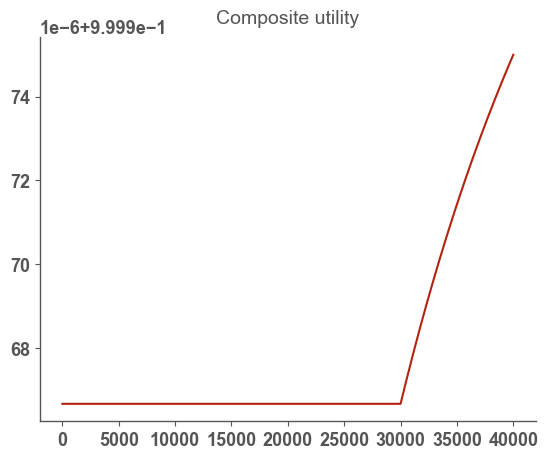

In [4]:
w = np.linspace(0, 40e3, 1000)
u = np.array([composite_crra_utility(wi, pref=preferences) for wi in w])
fig, ax = plt.subplots()
ax.plot(w, u)
ax.set_title("Composite utility");

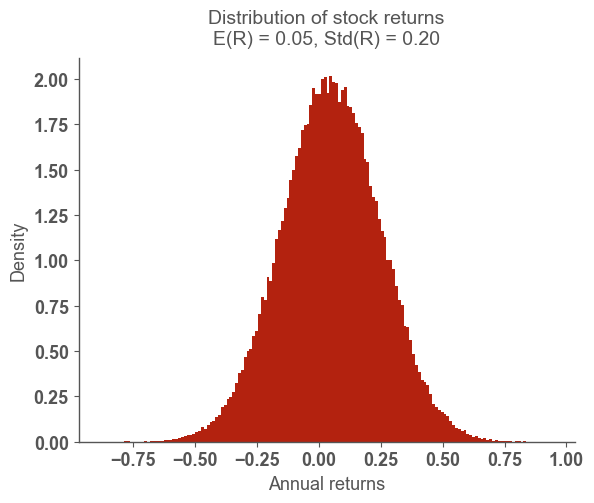

In [6]:
stock_returns = RiskyAsset(
    expected_return=0.05,    
    standard_deviation=0.2,
    distribution_type=DistributionType.NORMAL,
).draw(n_draws=100_000)
fig, ax = plt.subplots()
ax.hist(stock_returns, bins="auto", density=True)
stock_returns_mean = stock_returns.mean()
stock_returns_std = stock_returns.std()
ax.set_xlabel("Annual returns")
ax.set_ylabel("Density")
ax.set_title(
    f"Distribution of stock returns\nE(R) = {stock_returns_mean:.2f}, Std(R) = {stock_returns_std:.2f}"
);

In [7]:
initial_assets = Assets(
    tax_free=400_000.0, taxable=600_000.0, tax_rate=0.2, inflation_rate=0.02
)
preferences = Preferences(bequest_param=10)

sims = simulate_life_paths(
    n_sims=10,
    expected_return_risky=0.09,
    std_dev_return_risky=0.20,
    risk_free_rate=0.04,    
    pref=preferences,
    a=initial_assets,
    social_security=30_000.0,
    time_horizon=20,
    starting_age=65,
    is_male=False,
    rng_seed_offset=42,
    with_survival_probabilities=False,
    returns_distribution_type=DistributionType.NORMAL,
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 190.70it/s]


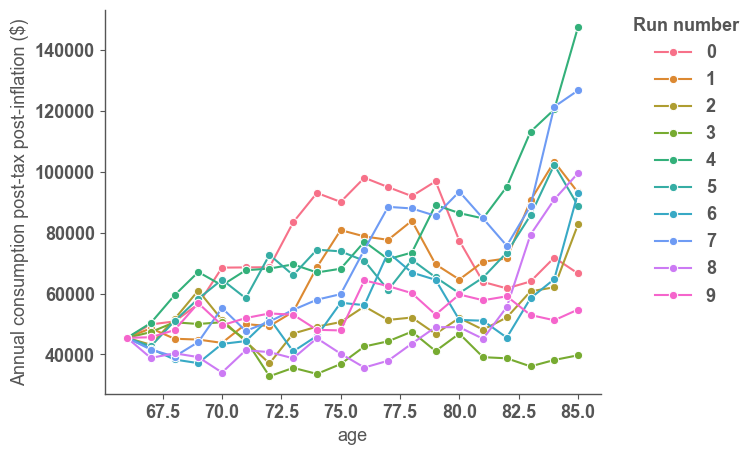

In [8]:
ax = sb.lineplot(
    sims, x="age", y="consumption_post_tax_post_inflation", hue="run_number", marker="o"
)
plt.legend(
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Run number"
)
ax.set_ylabel("Annual consumption post-tax post-inflation ($)");

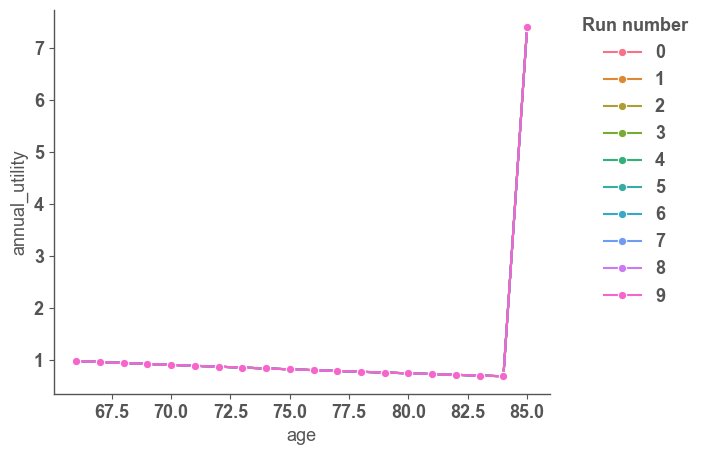

In [9]:
ax = sb.lineplot(sims, x="age", y="annual_utility", hue="run_number", marker="o")
plt.legend(
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Run number"
);

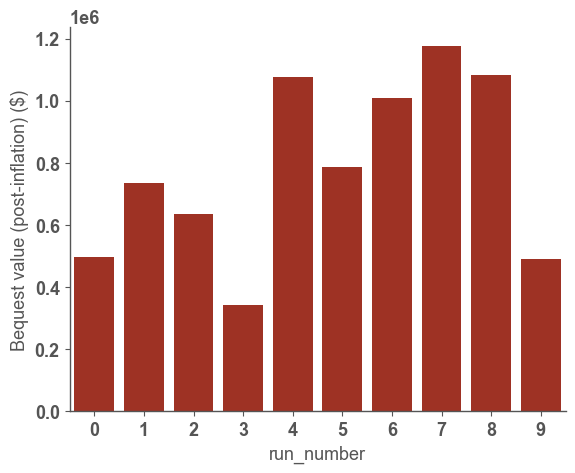

In [10]:
ax = sb.barplot(
    sims.sort("age")
    .group_by("run_number")
    .agg(col("bequest_post_inflation").last())
    .sort("run_number"),
    x="run_number",
    y="bequest_post_inflation",
)
ax.set_ylabel("Bequest value (post-inflation) ($)");

## Larger-scale sim

In [11]:
initial_assets = Assets(
    tax_free=400_000.0, taxable=600_000.0, tax_rate=0.2, inflation_rate=0.02
)
preferences = Preferences(bequest_param=10, rate_time_preference=0.02)

sims = simulate_life_paths(
    n_sims=1_000,
    expected_return_risky=0.09,
    std_dev_return_risky=0.20,
    risk_free_rate=0.04,    
    pref=preferences,
    a=initial_assets,
    social_security=30_000.0,
    time_horizon=35,
    starting_age=65,
    is_male=False,
    rng_seed_offset=42,
    with_survival_probabilities=False,
    returns_distribution_type=DistributionType.NORMAL,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 646.34it/s]


In [12]:
with pl.Config(tbl_rows=50):
    display(
        sims.group_by("age")
        .agg(
            col("consumption_post_tax_post_inflation")
            .quantile(0.5)
            .alias("median_consumption_post_tax_post_inflation"),
            col("consumption_fraction")
            .quantile(0.5)
            .alias("median_consumption_fraction"),
        )
        .sort("age")
    )

age,median_consumption_post_tax_post_inflation,median_consumption_fraction
i64,f64,f64
65,null,null
66,37613.746077,0.046579
67,39036.85512,0.046991
68,40166.744422,0.047427
69,41552.617763,0.047887
70,42763.522323,0.048374
71,43618.167049,0.048891
72,45393.799472,0.049438
73,46354.792554,0.05002


Text(0, 0.5, 'Age')

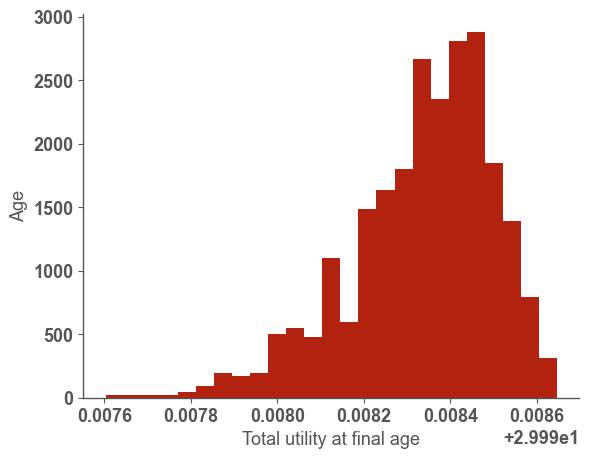

In [13]:
fig, ax = plt.subplots()
ax.hist(
    sims.sort("age")
    .group_by("run_number")
    .agg(col("total_utility").last())["total_utility"],
    bins="auto",
    density="True",
)
ax.set_xlabel("Total utility at final age")
ax.set_ylabel("Age")

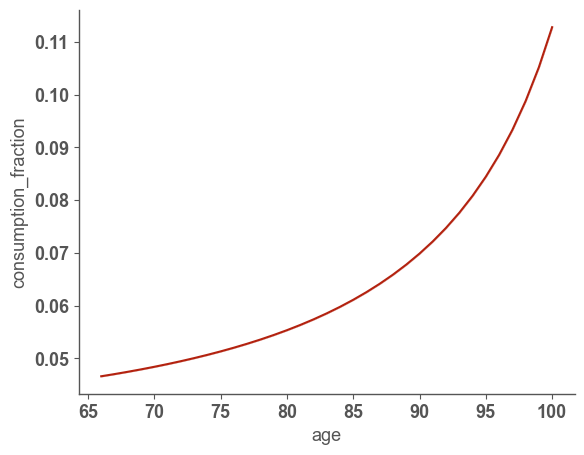

In [14]:
ax = sb.lineplot(sims, x="age", y="consumption_fraction");

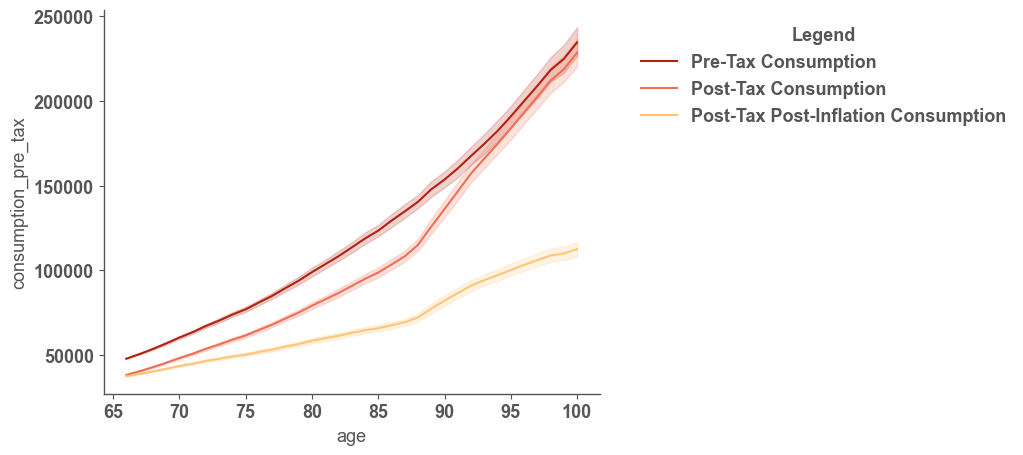

In [15]:
fig, ax = plt.subplots()
sb.lineplot(sims, x="age", y="consumption_pre_tax", ax=ax, label="Pre-Tax Consumption")
sb.lineplot(
    sims, x="age", y="consumption_post_tax", ax=ax, label="Post-Tax Consumption"
)
sb.lineplot(
    sims,
    x="age",
    y="consumption_post_tax_post_inflation",
    ax=ax,
    label="Post-Tax Post-Inflation Consumption",
)
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), title="Legend")

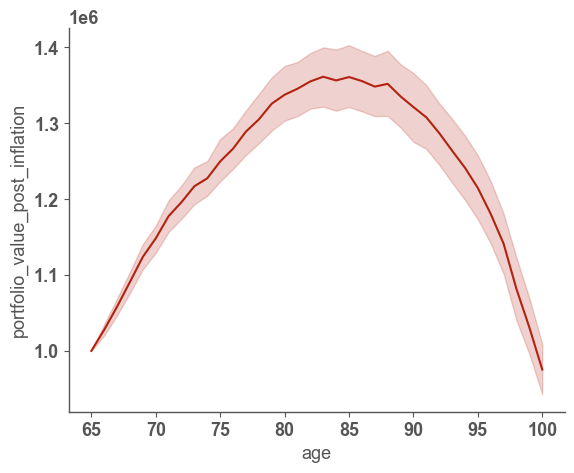

In [16]:
ax = sb.lineplot(
    sims,
    x="age",
    y="portfolio_value_post_inflation",
)